In [1]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
from scipy.stats import sem
from scipy.spatial.distance import squareform, pdist
from keras import backend as K
from keras.models import load_model
import tensorflow as tf


from models import vgg
from models.cvae import CVAE
from utils.angles import deg2bit, bit2deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg
from utils.losses import gaussian_kl_divergence_tf, gaussian_kl_divergence_np
from utils.losses  import von_mises_log_likelihood_tf, von_mises_log_likelihood_np
from utils.towncentre import load_towncentre
from utils.experiements import get_experiment_id

Using TensorFlow backend.


In [2]:
xtr, ytr_deg, xval, yval_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True, verbose=1)

image_height, image_width = xtr.shape[1], xtr.shape[2]
ytr_bit = deg2bit(ytr_deg)
yval_bit = deg2bit(yval_deg)
yte_bit = deg2bit(yte_deg)
yte_rad = np.deg2rad(yte_deg)

image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904


#### Loading pre-trained models

#### Biternion-VGG (Log-likelihood, fixed $\kappa=3$)

In [3]:
vgg_fixed_kappa = vgg.BiternionVGG(image_height=image_height,
                                   image_width=image_width,
                                   n_channels=3,
                                   predict_kappa=False,
                                   fixed_kappa_value=3.0)

vgg_fixed_kappa.model.load_weights('/Users/sergeyprokudin/BiternionNet/logs/best_models/fixed_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

In [4]:
results_fixed = dict()
#results_fixed['train'] = vgg_fixed_kappa.evaluate(xtr, ytr_deg, 'train')
results_fixed['validation'] = vgg_fixed_kappa.evaluate(xval, yval_deg, 'validation')
results_fixed['test'] = vgg_fixed_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 22.728342 ± 0.990586SEM
log-likelihood (validation) : -0.870462 ± 0.035802SEM
MAAD error (test) : 24.155143 ± 1.088582SEM
log-likelihood (test) : -0.929270 ± 0.039672SEM


#### Biternion-VGG (Log-likelihood, learned $\kappa$)

In [5]:
vgg_learned_kappa = vgg.BiternionVGG(image_height=image_height,
                                     image_width=image_width,
                                     n_channels=3,
                                     predict_kappa=True)

vgg_learned_kappa.model.load_weights('/Users/sergeyprokudin/BiternionNet/logs/best_models/learned_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

In [6]:
results_learned = dict()
#results_learned['train'] = vgg_learned_kappa.evaluate(xtr, ytr_deg, 'train')
results_learned['validation'] = vgg_learned_kappa.evaluate(xval, yval_deg, 'validation')
results_learned['test'] = vgg_learned_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 24.398405 ± 1.090128SEM
log-likelihood (validation) : -0.802889 ± 0.078568SEM
MAAD error (test) : 24.327137 ± 1.095842SEM
log-likelihood (test) : -0.764323 ± 0.066594SEM


#### Biternion-VGG (cosine-loss)

In [7]:
vgg_cosine = vgg.BiternionVGG(image_height=image_height,
                              image_width=image_width,
                              n_channels=3,
                              predict_kappa=False,
                              fixed_kappa_value=3.0)

vgg_cosine.model.load_weights('/Users/sergeyprokudin/BiternionNet/logs/best_models/cosine/vgg_bit_cosine_town.best.weights.h5')

In [8]:
results_cosine = dict()
#results_cosine['train'] = vgg_cosine.evaluate(xtr, ytr_deg, 'train')
results_cosine['validation'] = vgg_cosine.evaluate(xval, yval_deg, 'validation')
results_cosine['test'] = vgg_cosine.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 21.833931 ± 0.966800SEM
log-likelihood (validation) : -0.843196 ± 0.034713SEM
MAAD error (test) : 24.108348 ± 1.069605SEM
log-likelihood (test) : -0.926001 ± 0.038936SEM


#### Biternion-VGG (Von-Mises loss)

In [9]:
vgg_vm = vgg.BiternionVGG(image_height=image_height,
                          image_width=image_width,
                          n_channels=3,
                          predict_kappa=False,
                          fixed_kappa_value=3.0)

vgg_vm.model.load_weights('/Users/sergeyprokudin/BiternionNet/logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

In [10]:
results_vm = dict()
#results_vm['train'] = vgg_vm.evaluate(xtr, ytr_deg, 'train')
results_vm['validation'] = vgg_vm.evaluate(xval, yval_deg, 'validation')
results_vm['test'] = vgg_vm.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 22.974047 ± 0.999363SEM
log-likelihood (validation) : -0.883493 ± 0.036697SEM
MAAD error (test) : 24.156092 ± 1.083819SEM
log-likelihood (test) : -0.925846 ± 0.039583SEM


#### CVAE model 

In [11]:
n_u = 8
cvae_best = CVAE(n_hidden_units=n_u)
cvae_ckpt_path = '/Users/sergeyprokudin/BiternionNet/logs/best_models/cvae/kl_reduction_exepriments/cvae.full_model.overall_best.weights.hdf5'
cvae_best.full_model.load_weights(cvae_ckpt_path)

In [12]:
results_cvae = dict()
# results_cvae['train'] = cvae_best.evaluate(xtr, ytr_deg, 'train')
results_cvae['validation'] = cvae_best.evaluate(xval, yval_deg, 'validation')
results_cvae['test'] = cvae_best.evaluate(xte, yte_deg, 'test')

MAAD error (validation) : 28.666543 ± 1.278829SEM
ELBO (validation) : -0.634788 ± 0.044469SEM
KL-div (validation) : 0.216362 ± 0.014096SEM
log-likelihood (validation) : -1.163809±0.095164SEM
MAAD error (test) : 30.184967 ± 1.270261SEM
ELBO (test) : -0.730456 ± 0.050259SEM
KL-div (test) : 0.231224 ± 0.016260SEM
log-likelihood (test) : -1.344666±0.109727SEM


In [54]:
y_pred = cvae_best.full_model.predict([xte, yte_bit])
mu_prior = y_pred[:, 0:self.n_u]
log_sigma_prior = y_pred[:, self.n_u:self.n_u*2]
mu_encoder = y_pred[:, self.n_u*2:self.n_u*3]
log_sigma_encoder = y_pred[:, self.n_u*3:self.n_u*4]
mu_pred = y_pred[:, self.n_u*4:self.n_u*4+2]
kappa_pred = y_pred[:, self.n_u*4+2:]

In [13]:
from utils.losses import von_mises_log_likelihood_np

#### Using Maximum Expected Utility for calculation

In [15]:
def maximum_expected_utility(ypreds):
    ix = np.argmin(np.sum(squareform(pdist(ypreds, 'euclidean')), axis=1))
    return float(ypreds[ix])

In [16]:
n_samples = 20

cvae_mu_rad_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_kappa_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_mu_bit_preds = np.zeros([n_samples, xte.shape[0], 2])

for i in range(0, n_samples):
    cvae_preds = cvae_best.decoder_model.predict(xte)
    cvae_mu_bit_preds[i,:,:] = cvae_preds[:,0:2]
    cvae_mu_rad_preds[i,:,:] = np.deg2rad(bit2deg(cvae_preds[:,0:2])).reshape(-1,1)
    cvae_kappa_preds[i,:,:] = cvae_preds[:,2].reshape(-1,1)

In [73]:
n_samples = 10
n_u = 8 

cvae_mu_rad_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_kappa_preds  = np.zeros([n_samples, xte.shape[0], 1])
cvae_mu_bit_preds = np.zeros([n_samples, xte.shape[0], 2])

for i in range(0, n_samples):
    y_pred = cvae_best.full_model.predict([xte, yte_bit])
    mu_prior = y_pred[:, 0:n_u]
    log_sigma_prior = y_pred[:, n_u:n_u*2]
    mu_encoder = y_pred[:, n_u*2:n_u*3]
    log_sigma_encoder = y_pred[:, n_u*3:n_u*4]
    mu_pred = y_pred[:, n_u*4:n_u*4+2]
    kappa_pred = y_pred[:, n_u*4+2:]
    cvae_mu_bit_preds[i,:,:] = mu_pred
    cvae_mu_rad_preds[i,:,:] = np.deg2rad(bit2deg(cvae_preds[:,0:2])).reshape(-1,1)
    cvae_kappa_preds[i,:,:] = kappa_pred

In [74]:
cvae_mu_rad_preds_mae = [maximum_expected_utility(cvae_mu_rad_preds[:,i,:]) for i in range(0, cvae_mu_rad_preds.shape[1])]
maad_errors = maad_from_deg(np.rad2deg(cvae_mu_rad_preds_mae), yte_deg)
print("MAAD error (test, CVAE-MAE) : %f ± %fSEM" % (np.mean(maad_errors), sem(maad_errors)))

MAAD error (test, CVAE-MAE) : 88.299903 ± 1.713441SEM


#### Saving predictions from different model

In [18]:
vm_preds = vgg_vm.model.predict(xte)
vm_preds_mu_rad = np.deg2rad(bit2deg(vm_preds))
vm_preds_kappa = np.ones([xte.shape[0],1])*3
vm_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, vm_preds[:,0:2], vm_preds_kappa)

fixed_preds = vgg_fixed_kappa.model.predict(xte)
fixed_preds_mu_rad = np.deg2rad(bit2deg(fixed_preds))
fixed_preds_kappa = np.ones([xte.shape[0],1])*3
fixed_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, fixed_preds[:,0:2], fixed_preds_kappa)

learned_preds = vgg_learned_kappa.model.predict(xte)
learned_preds_mu_rad = np.deg2rad(bit2deg(learned_preds[:,0:2]))
learned_preds_kappa = learned_preds[:,2:]
learned_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, learned_preds[:,0:2], learned_preds_kappa)

In [19]:
from utils.losses import log_bessel_approx_np

def vm_pdf(vals, mu_rad, kappa):
    return np.exp(kappa * np.cos(vals-mu_rad)) / (2* np.pi * np.exp(log_bessel_approx_np(kappa)))

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_vm_dists(fid):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    
    axs[0].imshow(xtr[fid])
    
    def _plt_vgg(axis, mu_rad_preds, kappa_preds, method_name):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_rad_preds[fid], kappa_preds[fid])))
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s ()" % method_name)
        axis.set_ylim([0, 2.0])
        
    def _plt_cvae(axis):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        for sid in range(0, n_samples):
            axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, cvae_mu_rad_preds[sid, fid], cvae_kappa_preds[sid, fid])))    
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("CVAE")
        axis.set_ylim([0, 2.0])
        
    _plt_vgg(axs[1], fixed_preds_mu_rad, fixed_preds_kappa, 'original (Von-Mises loss)')
    _plt_vgg(axs[2], fixed_preds_mu_rad, fixed_preds_kappa, 'fixed kappa')
    _plt_vgg(axs[3], learned_preds_mu_rad, learned_preds_kappa, 'learned kappa')
    _plt_cvae(axs[4])
    fig.suptitle("frame id =%d" %fid)
    #plt.plot((ytr_deg, x2), (y1, y2), 'k-')
    plt.show()

#####  dataset desc http://www.robots.ox.ac.uk/~lav/Papers/benfold_reid_iccv2011/benfold_reid_iccv2011.pdf
#####  https://www.youtube.com/watch?v=eupXTJM_TAw (Demo)

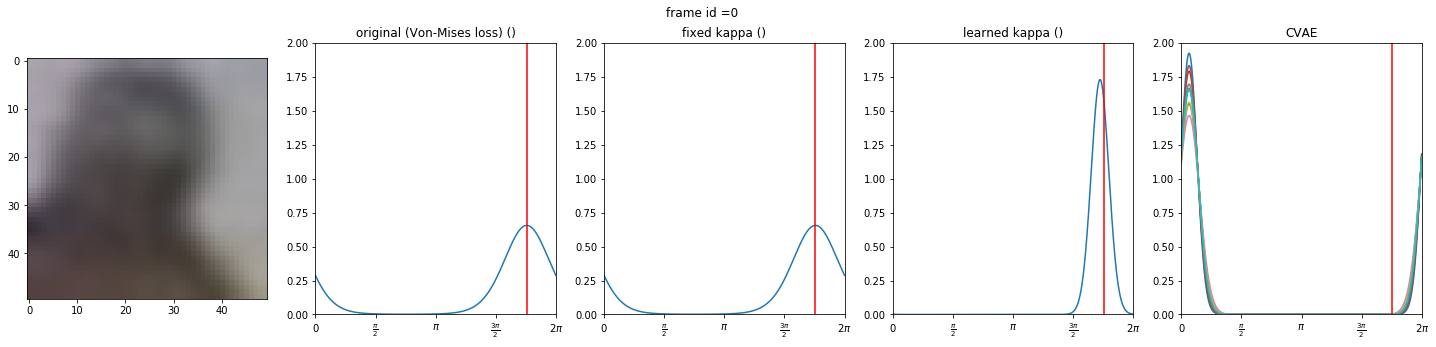

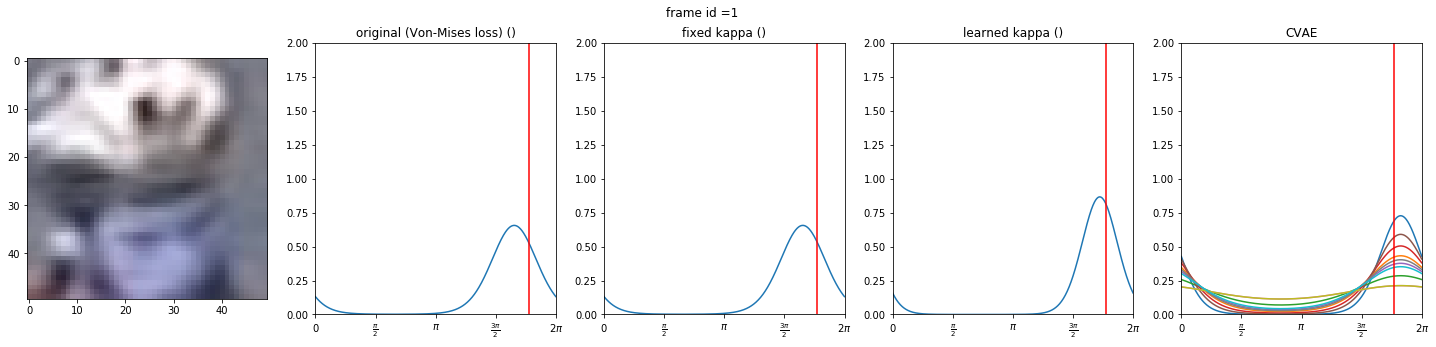

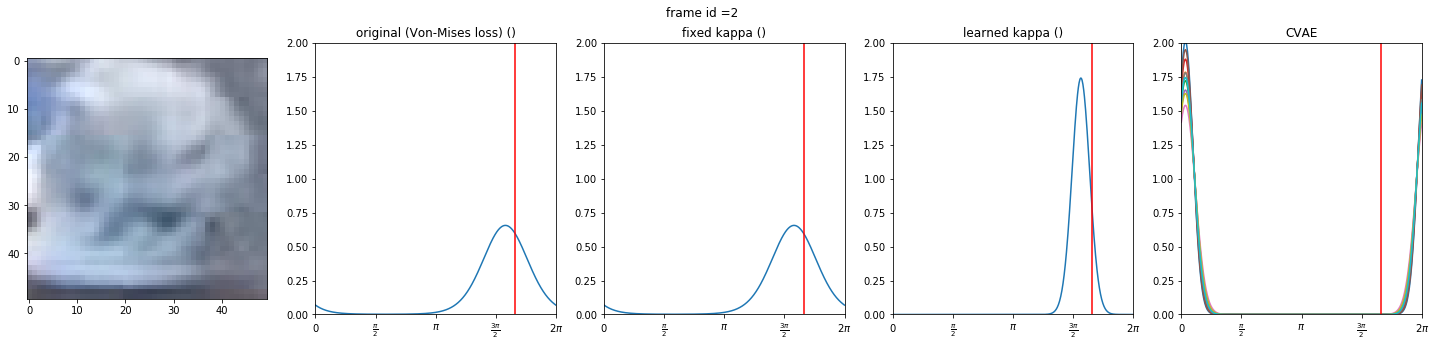

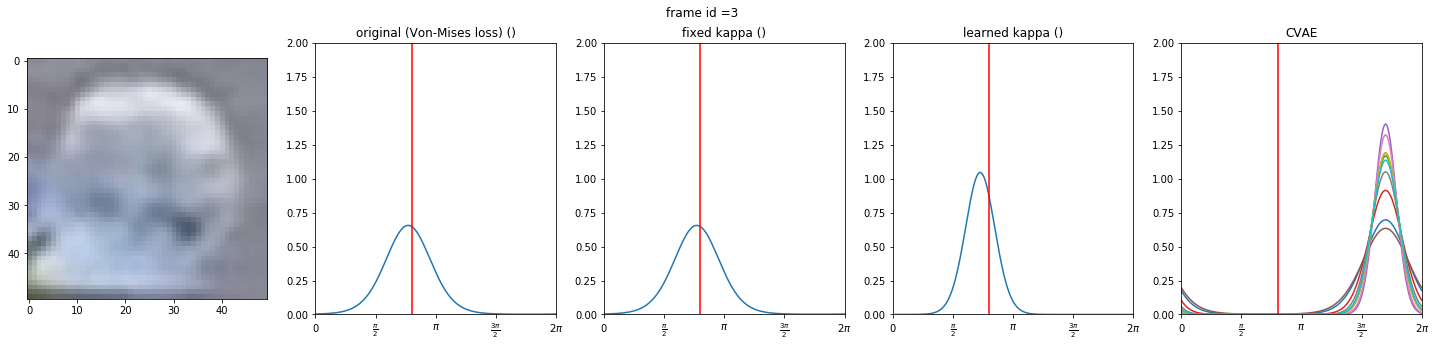

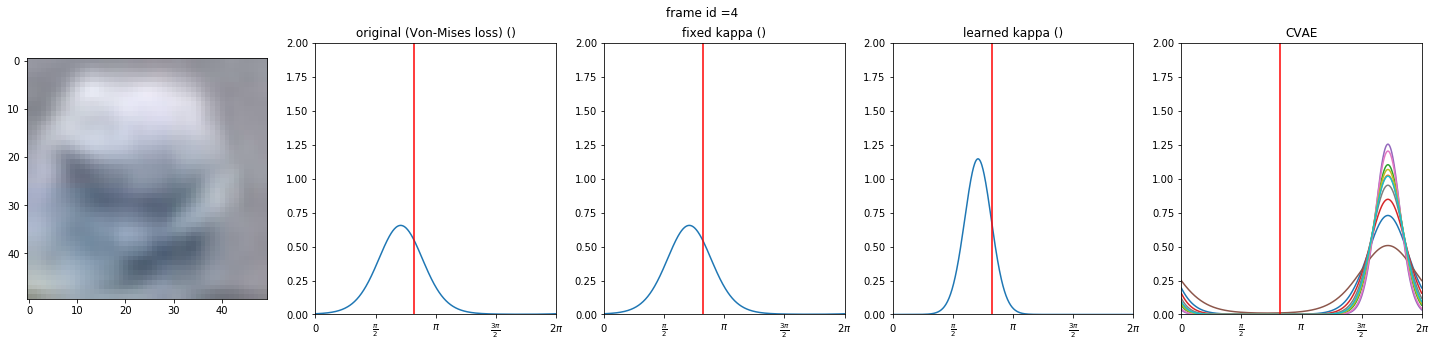

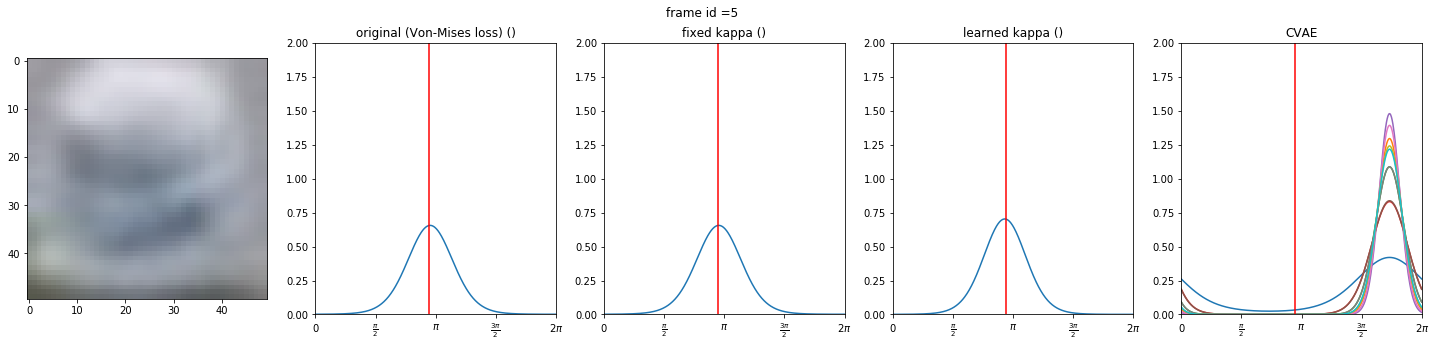

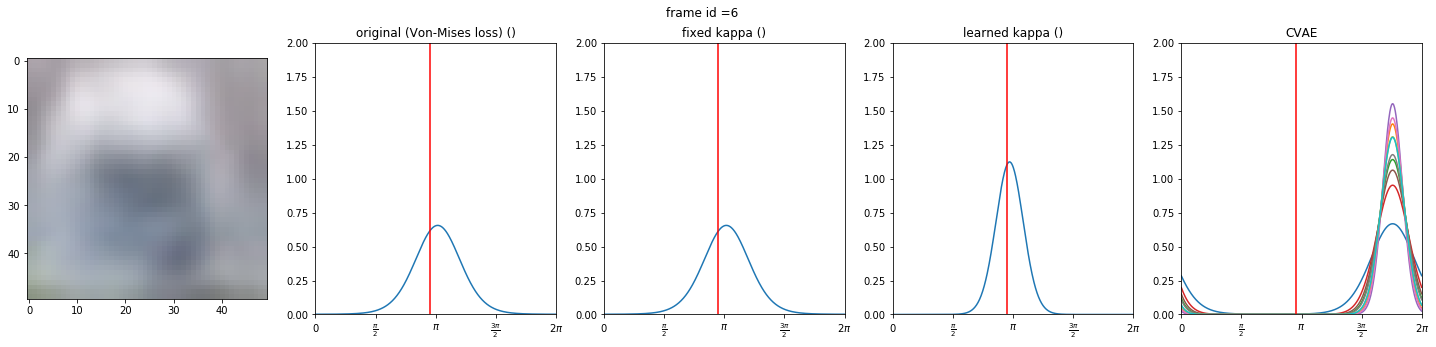

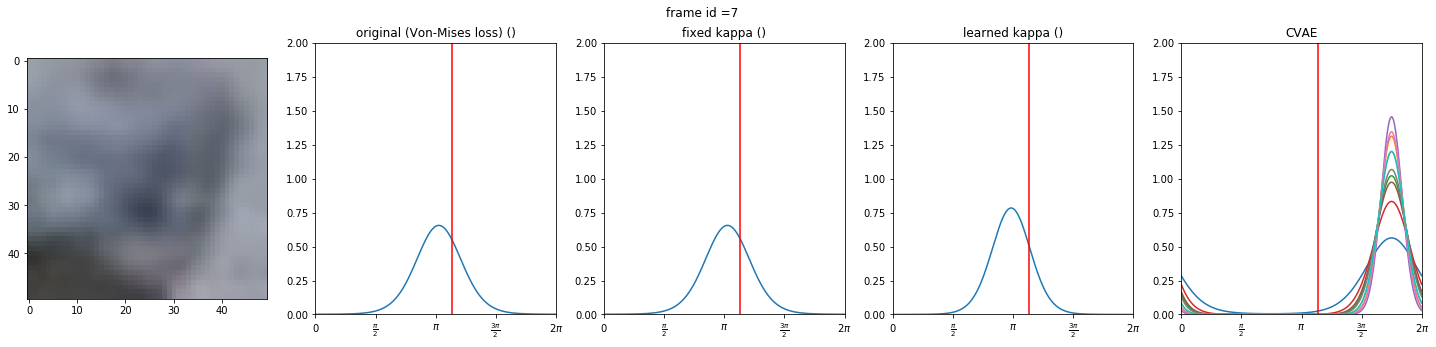

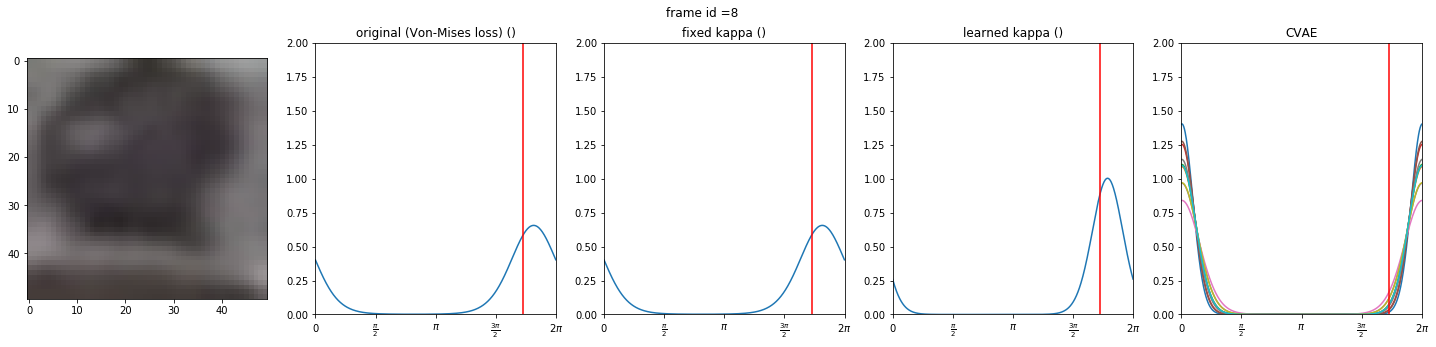

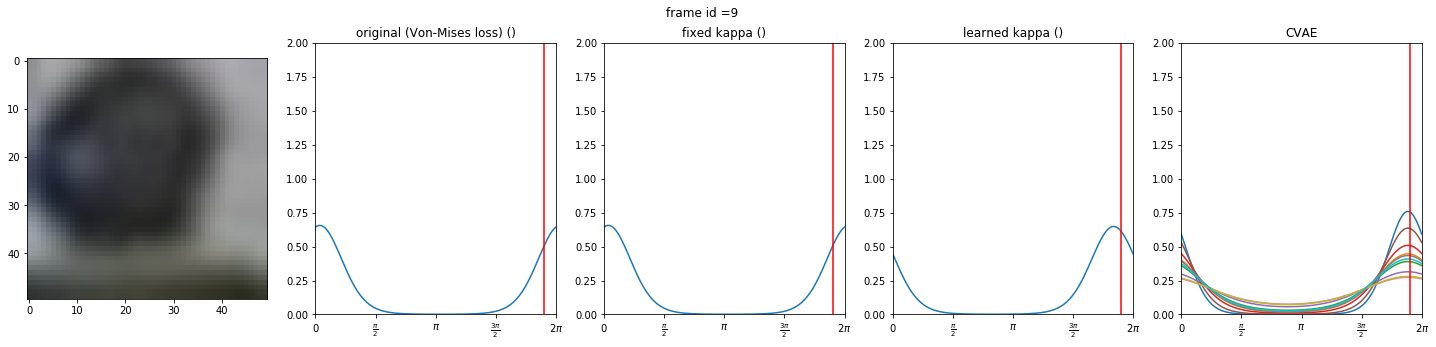

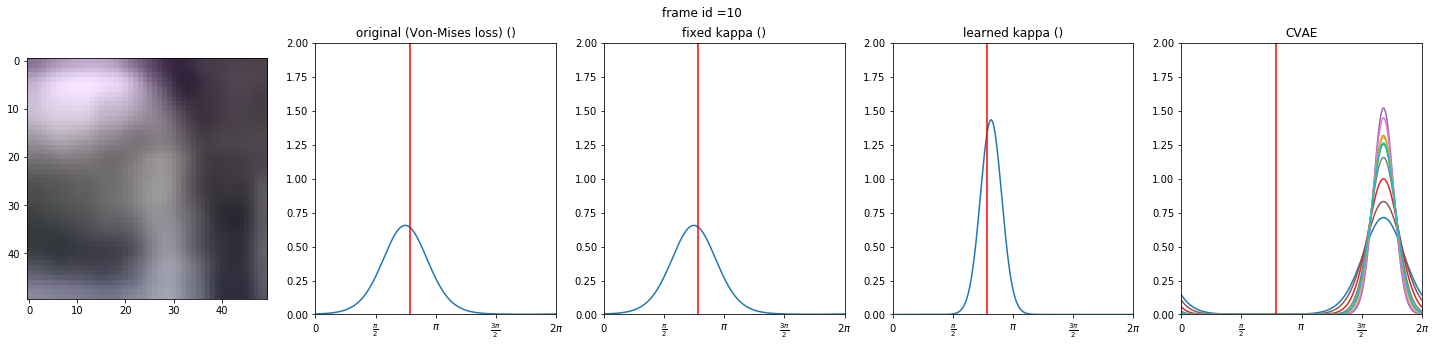

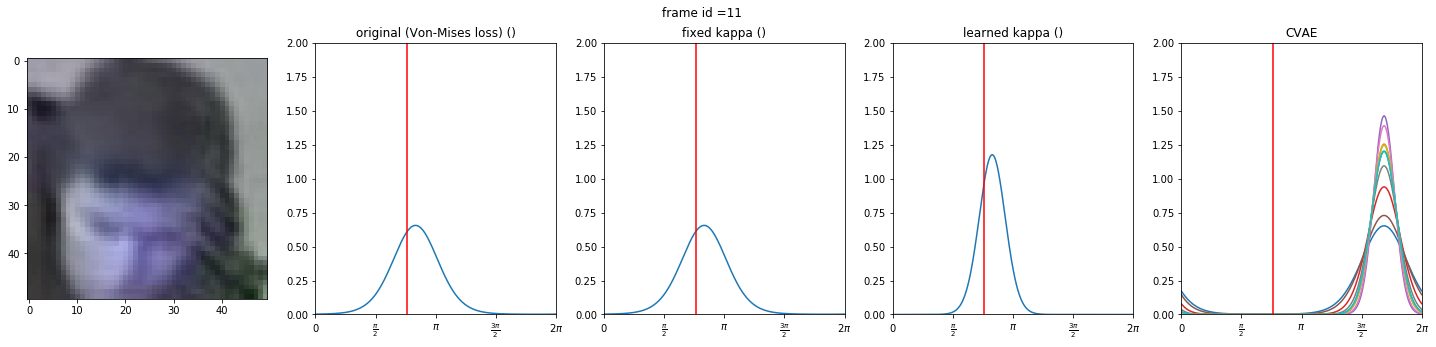

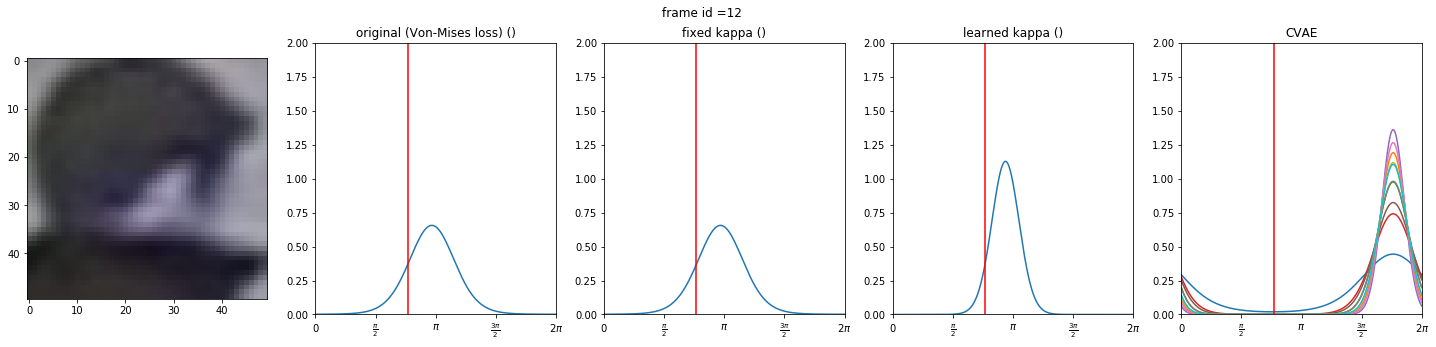

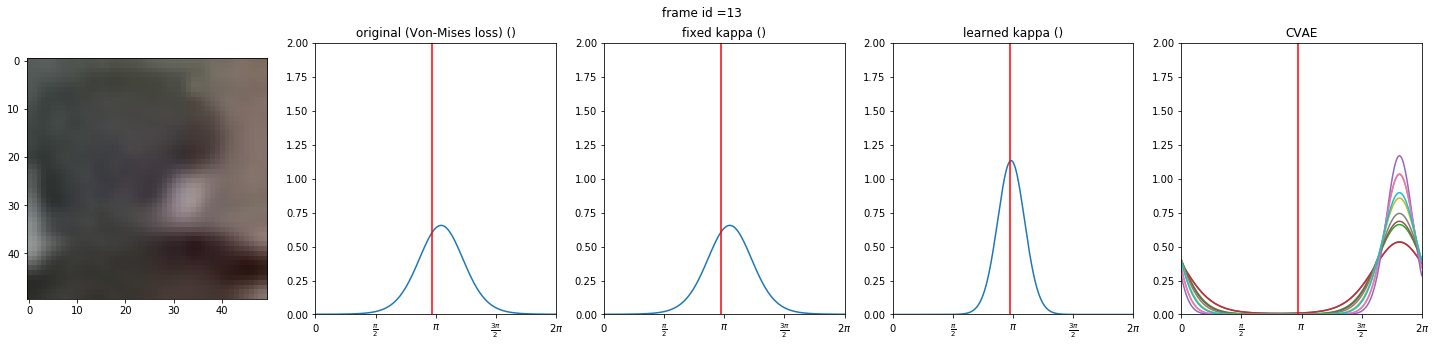

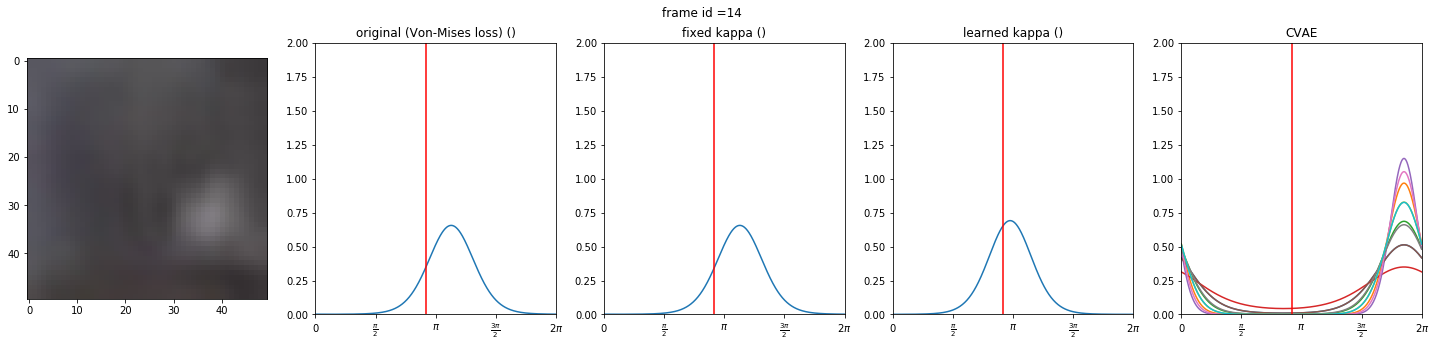

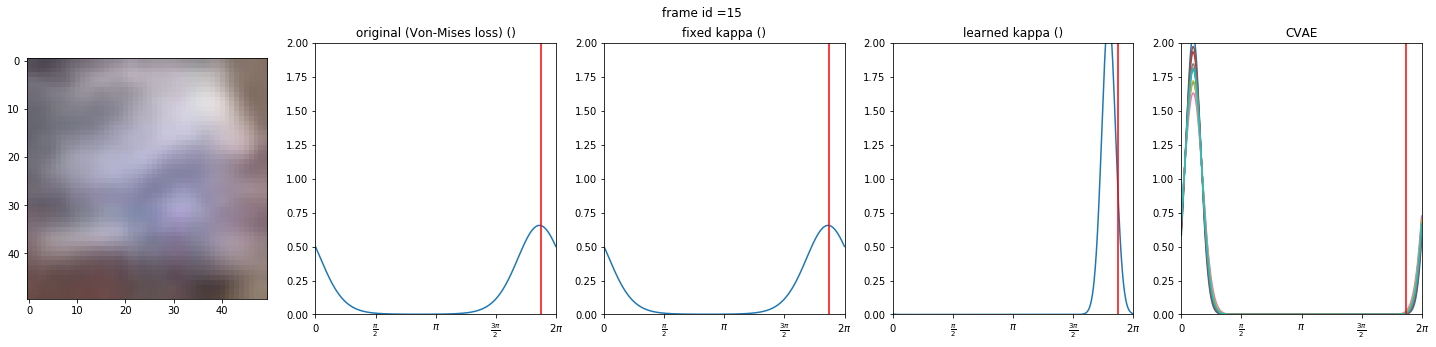

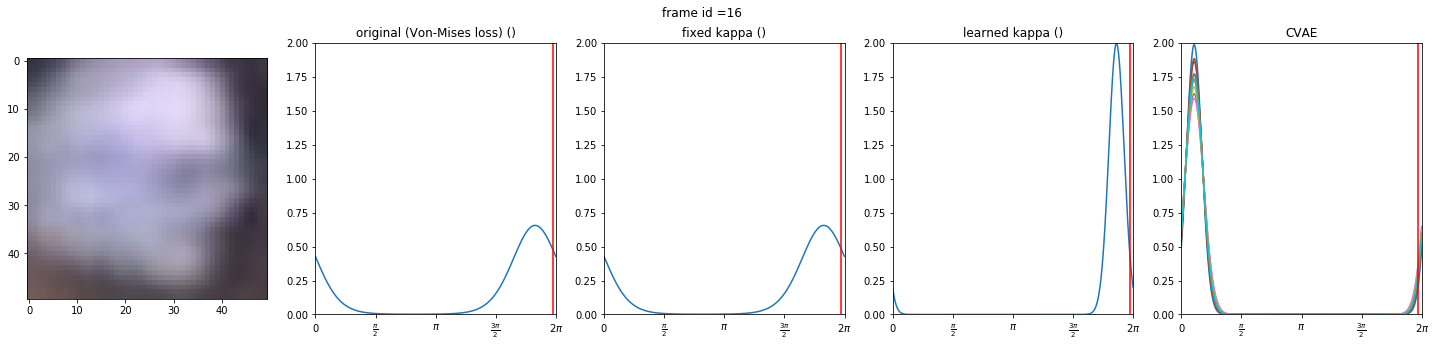

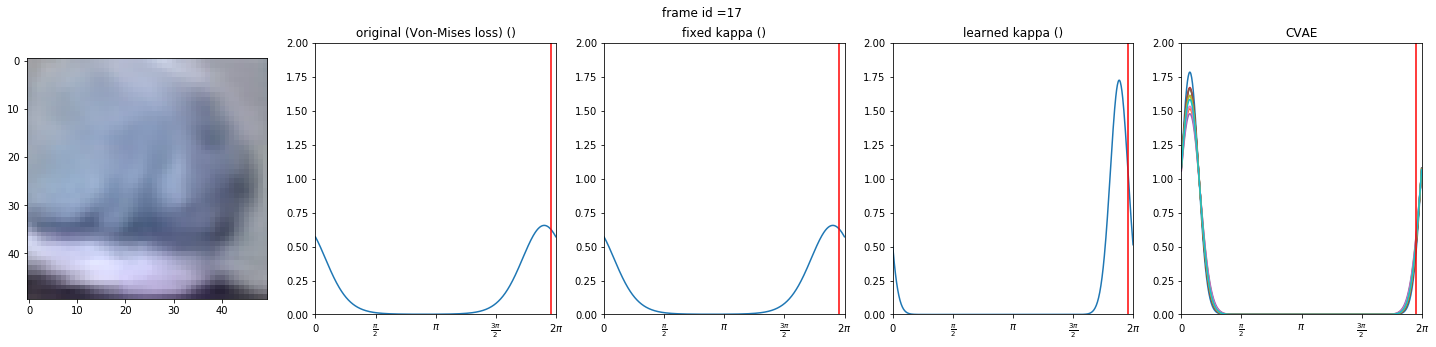

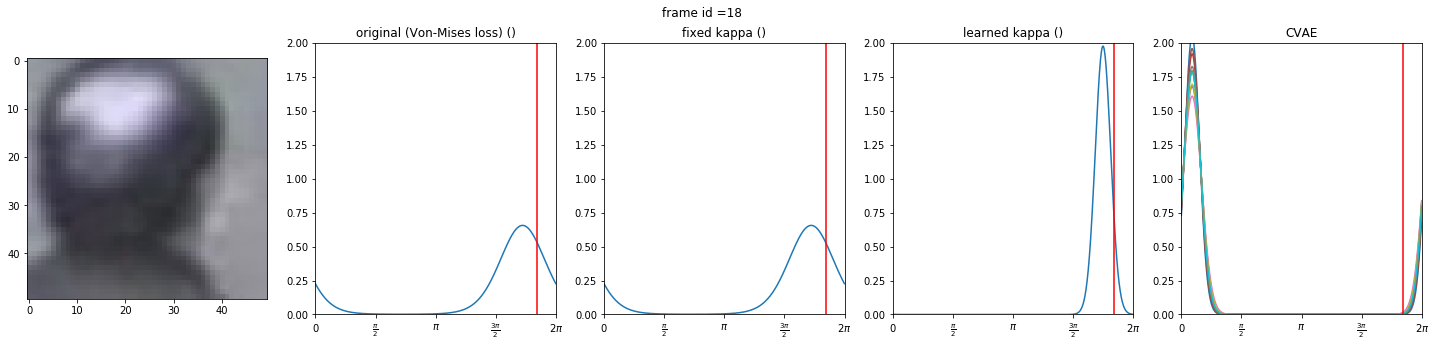

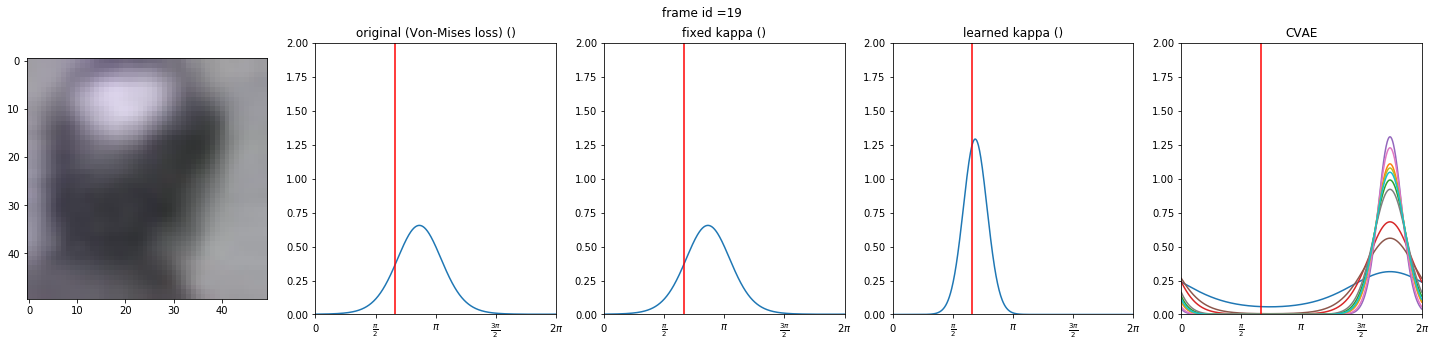

In [76]:
import time 

for fid in range(0, 20):
    plot_vm_dists(fid)

In [22]:
cvae_preds_full = cvae_best.full_model.predict([xte, yte_bit])

In [23]:
mu_prior = cvae_preds_full[:, 0:cvae_best.n_u]
log_sigma_prior = cvae_preds_full[:, cvae_best.n_u:cvae_best.n_u*2]
mu_encoder = cvae_preds_full[:, cvae_best.n_u*2:cvae_best.n_u*3]
log_sigma_encoder = cvae_preds_full[:, cvae_best.n_u*3:cvae_best.n_u*4]
mu_pred = cvae_preds_full[:, cvae_best.n_u*4:cvae_best.n_u*4+2]
kappa_pred = cvae_preds_full[:, cvae_best.n_u*4+2:]

In [24]:
np.exp(log_sigma_prior[2])

array([  0.77836674,   0.9079271 ,   0.88959575,   0.88973671,
         1.21632481,   0.93938619,  10.3292017 ,   4.37691402], dtype=float32)

#### The problem is that encoder and prior generate exactly the same distributions for each input

$ p(u|x) = q(u|x,\phi) = p(u)$ 

In [25]:
mu_prior[0:5]

array([[  1.39329821e-01,   2.85292752e-02,  -1.11054741e-01,
         -4.80715930e-02,   1.03563279e-01,  -1.81253068e-02,
          3.24439335e+00,  -1.97856462e+00],
       [  1.08206570e-01,  -6.65742680e-02,  -1.19412601e-01,
         -6.26189075e-03,   1.58110648e-01,  -5.98949976e-02,
         -3.96084517e-01,   2.29677987e+00],
       [  1.28133550e-01,   1.36815123e-02,  -1.73080742e-01,
         -5.60191497e-02,   2.22083598e-01,  -1.20337997e-02,
          4.73618221e+00,  -6.42508984e-01],
       [  9.37917531e-02,  -1.30214602e-01,  -1.24740444e-01,
         -1.61723215e-02,   5.34741953e-02,  -9.74682793e-02,
         -3.36093378e+00,   1.34999597e+00],
       [  9.78330746e-02,  -1.19585454e-01,  -1.05840191e-01,
          2.75364332e-03,   1.71631090e-02,  -7.36409575e-02,
         -3.19414449e+00,   3.96965742e-01]], dtype=float32)

In [26]:
mu_encoder[0:5]

array([[  1.26928538e-01,   4.35925759e-02,  -9.92849618e-02,
         -3.21640074e-02,   7.53125325e-02,  -1.37701072e-02,
          3.25229096e+00,  -2.01351905e+00],
       [  1.07577167e-01,  -2.11343542e-03,  -8.60063136e-02,
          1.49458442e-02,   1.02862731e-01,  -2.61018518e-02,
          1.54541290e+00,  -4.27850783e-01],
       [  1.04029298e-01,   4.19423245e-02,  -1.63488671e-01,
         -3.04799974e-02,   1.85303390e-01,   8.63982365e-04,
          4.66326666e+00,  -7.12084651e-01],
       [  9.59884301e-02,  -1.53088927e-01,  -1.45619556e-01,
         -3.17831859e-02,   1.01336062e-01,  -1.30420685e-01,
         -3.54123521e+00,   2.05678797e+00],
       [  9.74406376e-02,  -1.44663885e-01,  -1.33433849e-01,
         -1.89173073e-02,   9.77285653e-02,  -1.15565687e-01,
         -3.13407254e+00,   1.81711841e+00]], dtype=float32)

#### Generating predictions on random images

In [27]:
black_img = np.zeros(xte[1].shape)
white_img = np.ones(xte[1].shape)
random_img1 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])
random_img2 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])
random_img3 = np.random.rand(xte[1].shape[0], xte[1].shape[1], xte[1].shape[2])

In [28]:
cvae_best.full_model.predict

<bound method Model.predict of <keras.engine.training.Model object at 0x13c39b978>>

In [29]:
cvae_best.decoder_model.predict(black_img.reshape([1,50,50,3]))

array([[-0.98054254, -0.19630675,  3.40133739]], dtype=float32)

In [30]:
def plot_cvae_preds(img, cvae_model, n_samples=10):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].imshow(img)
    axs[1].set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axs[1].set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axs[1].set_ylim([0, 2.0])
    for i in range(0, n_samples):
        preds = cvae_best.decoder_model.predict(img.reshape([1,50,50,3]))
        mu_preds = np.deg2rad(bit2deg(preds[:, 0:2]))
        kappa_preds = preds[:,2:]
        axs[1].plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_preds[0], kappa_preds[0]))) 
    return

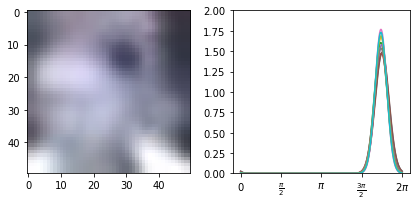

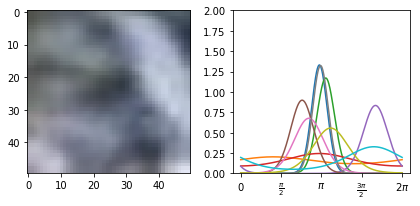

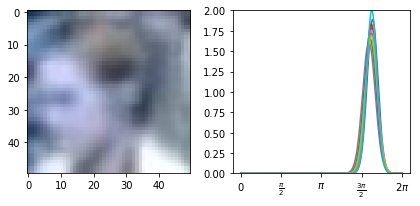

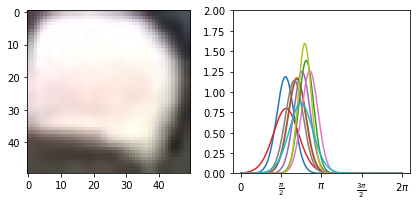

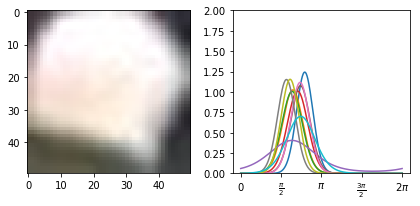

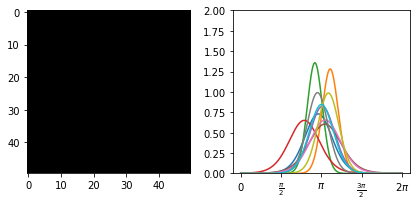

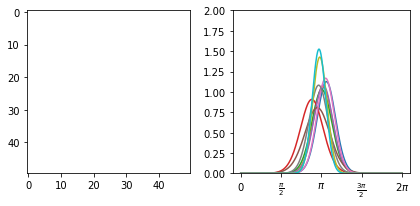

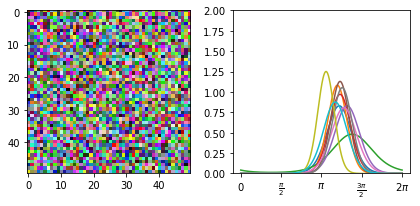

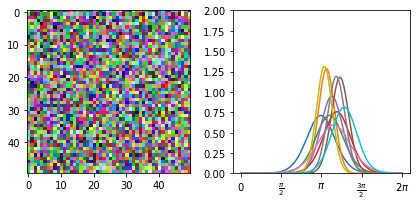

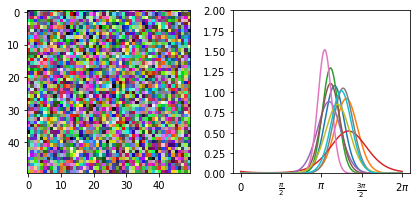

In [31]:
for i in range(0,5):
    plot_cvae_preds(xte[i], cvae_best, 10)
plot_cvae_preds(black_img, cvae_best, 10)
plot_cvae_preds(white_img, cvae_best, 10)
plot_cvae_preds(random_img1, cvae_best, 10)
plot_cvae_preds(random_img2, cvae_best, 10)
plot_cvae_preds(random_img3, cvae_best, 10)

In [32]:
loss = cvae_best.full_model.evaluate([xte, yte_bit],yte_bit, verbose=0)